In [32]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate, StratifiedKFold
from skopt.space import Real, Integer
from skopt import BayesSearchCV
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

<b>Loading Data<b>

In [2]:
df= pd.read_csv(r"C:\Users\kibe\Desktop\Projects\HR\HR Employee Attrition.csv")

In [3]:
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [4]:
#exploring the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

In [7]:
#checking for variables with a constant value
val = df.apply(lambda x: len(x.unique()))
val[val ==1 ].index

Index(['EmployeeCount', 'Over18', 'StandardHours'], dtype='object')

'EmployeeCount', 'Over18', 'StandardHours' variables have a constant value so the best thing to do is to drop them

In [8]:
# dropping the variables
df.drop(['EmployeeCount', 'Over18', 'StandardHours'], axis = 1, inplace = True)

In [9]:
#to get categorical variables
nom_df=df.select_dtypes(include=['object'])
nom_df.head()

,Attrition,BusinessTravel,Department,EducationField,Gender,JobRole,MaritalStatus,OverTime
0,Yes,Travel_Rarely,Sales,Life Sciences,Female,Sales Executive,Single,Yes
1,No,Travel_Frequently,Research & Development,Life Sciences,Male,Research Scientist,Married,No
2,Yes,Travel_Rarely,Research & Development,Other,Male,Laboratory Technician,Single,Yes
3,No,Travel_Frequently,Research & Development,Life Sciences,Female,Research Scientist,Married,Yes
4,No,Travel_Rarely,Research & Development,Medical,Male,Laboratory Technician,Married,No


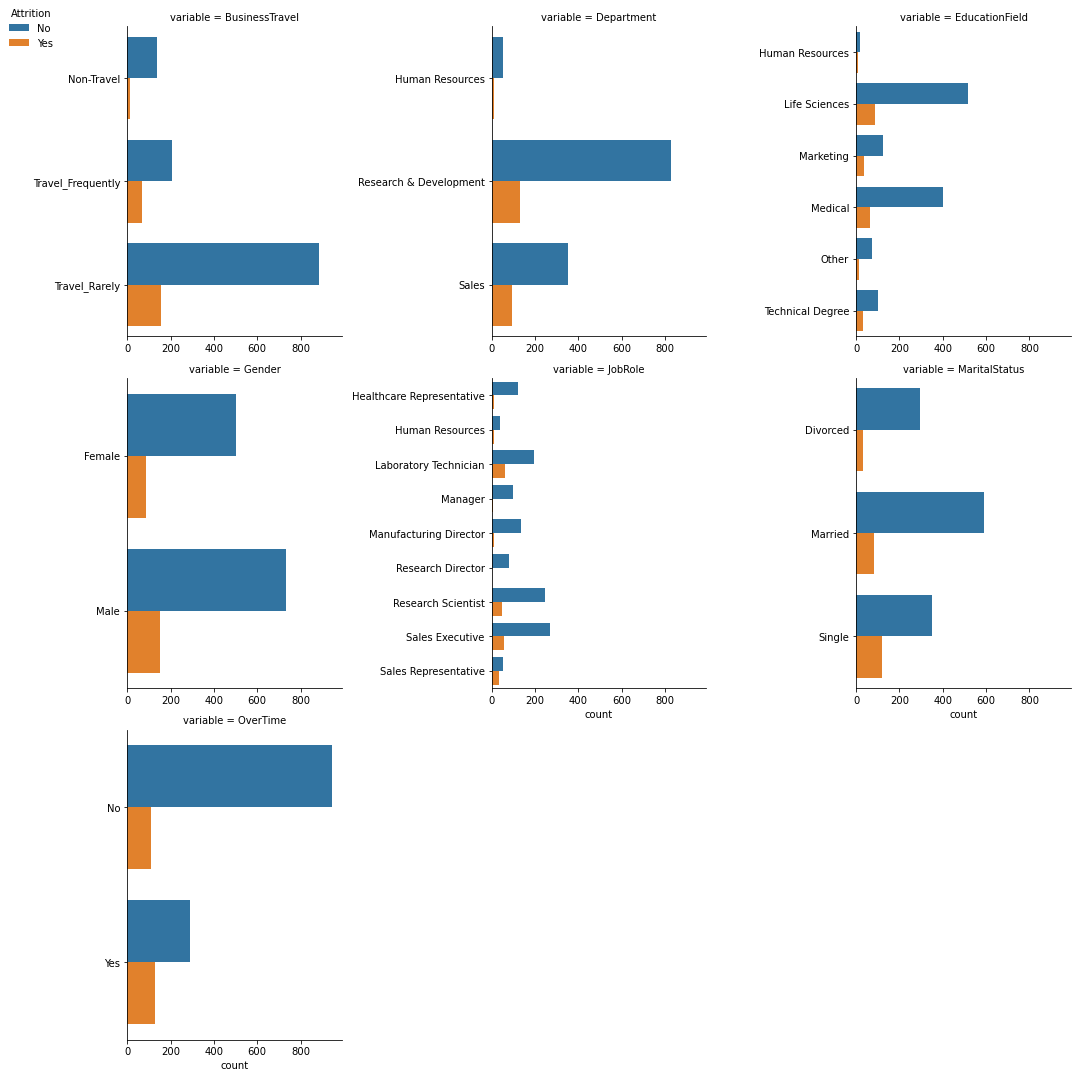

In [10]:
#counting category per variable
val = nom_df.melt(value_name = 'category', id_vars = 'Attrition')\
    .groupby(['variable', 'category', 'Attrition']).size().to_frame('count').reset_index()
g = sns.catplot(
    data=val, x='count', y='category', col='variable', hue = 'Attrition', kind='bar', col_wrap=3,
    orient = 'h', sharey = False
)

# show x-label for all facet
for ax in g.axes.flatten():
    ax.tick_params(labelbottom=True)
    
sns.move_legend(g, 'upper left')
g.set(ylabel = None)

# Description Analysis Summary
1. Most employees are male and they attrite more<br>
2. Those who attrite more are laboratory technicians followed by sales executives<br>
3. Those who attrite more are in the Research and Development and Life Sciences EducationField<br>
4. Those who attrite more are those who travel rarely<br>
5. The company had 237 employees quit out of 1470

In [11]:
#Ordinal variables
ordinal = ['Education', 'EnvironmentSatisfaction', 'JobLevel', 'JobInvolvement', 'JobSatisfaction', 'PerformanceRating', 'RelationshipSatisfaction', 'WorkLifeBalance', 'StockOptionLevel']
ordinal_df = df[ordinal]

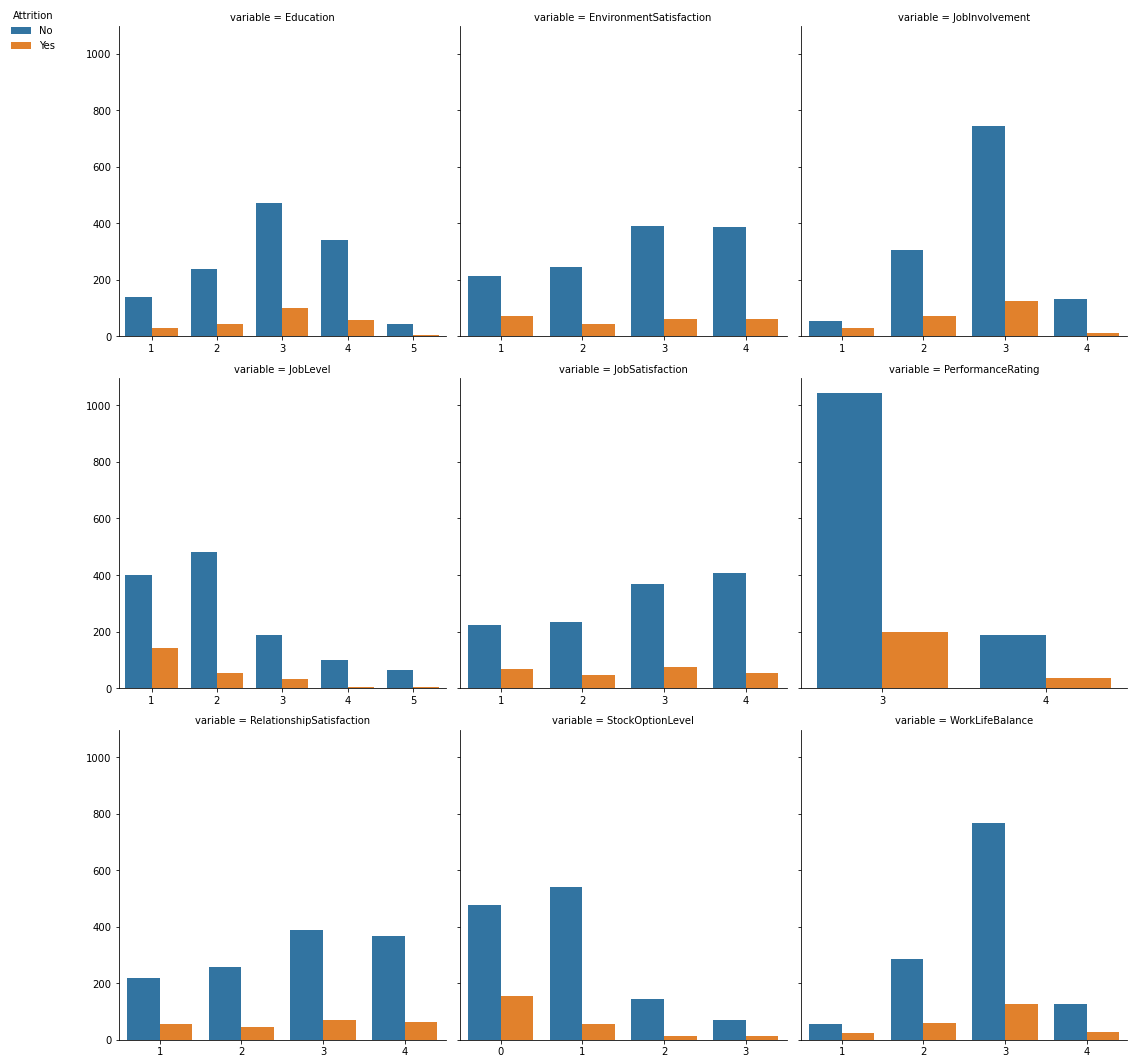

In [13]:
val = pd.concat([df['Attrition'], ordinal_df], axis = 1)\
    .melt(value_name = 'category', id_vars = 'Attrition')\
    .groupby(['variable', 'category', 'Attrition']).size().to_frame('count').reset_index()
g = sns.catplot(
    data=val, x='category', y='count', col='variable', hue = 'Attrition', kind='bar', col_wrap=3,
    sharex = False
)

# show x-label for all facet
for ax in g.axes.flatten():
    ax.tick_params(labelbottom=True)
    
sns.move_legend(g, 'upper left', bbox_to_anchor=(-0.05, 1))
g.set(ylabel = None, xlabel = None)

1. Most employees who leave have a Bachelors and those who stay have a Doctorate 
2. Most employees with high job involve tend to leave
3. Most employees wwith high job satisfaction leave


<b>Checking numerical variables<b>

In [15]:
#checking numerical variables
numeric = df.describe().columns
num_df = df[numeric].reset_index(drop = True).drop(ordinal, axis = 1)
num_df.describe()

,Age,DailyRate,DistanceFromHome,EmployeeNumber,HourlyRate,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000
mean,36.923810,802.485714,9.192517,1024.865306,65.891156,6502.931293,14313.103401,2.693197,15.209524,11.279592,2.799320,7.008163,4.229252,2.187755,4.123129
std,9.135373,403.509100,8.106864,602.024335,20.329428,4707.956783,7117.786044,2.498009,3.659938,7.780782,1.289271,6.126525,3.623137,3.222430,3.568136
min,18.000000,102.000000,1.000000,1.000000,30.000000,1009.000000,2094.000000,0.000000,11.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,465.000000,2.000000,491.250000,48.000000,2911.000000,8047.000000,1.000000,12.000000,6.000000,2.000000,3.000000,2.000000,0.000000,2.000000
50%,36.000000,802.000000,7.000000,1020.500000,66.000000,4919.000000,14235.500000,2.000000,14.000000,10.000000,3.000000,5.000000,3.000000,1.000000,3.000000
75%,43.000000,1157.000000,14.000000,1555.750000,83.750000,8379.000000,20461.500000,4.000000,18.000000,15.000000,3.000000,9.000000,7.000000,3.000000,7.000000
max,60.000000,1499.000000,29.000000,2068.000000,100.000000,19999.000000,26999.000000,9.000000,25.000000,40.000000,6.000000,40.000000,18.000000,15.000000,17.000000


<b>Checking for outliers<b>

In [16]:
#function to check for outliers
def outlier_check(data):
    print(f'Count of outliers:')
    outlier_var = 0
    for val in data.columns:
        Q1,Q3 = np.percentile(data[val].sort_values(), [25,75])
        IQR = Q3 - Q1
        min_ = Q1 - (1.5 * IQR)
        max_ = Q3 + (1.5 * IQR)

        tagging = data[val].apply(lambda x: 1 if (x < min_ or x > max_) else 0)
        count = tagging[tagging == 1].sum()
        if count > 0: outlier_var = outlier_var + 1
        print(f'  {val} -- Count: {count} Percentage: {int(round(count/data.shape[0]*100, 0))}%')
    print(f'Total number of variables with outliers: {outlier_var}')
    
outlier_check(num_df)

Count of outliers:
  Age -- Count: 0 Percentage: 0%
  DailyRate -- Count: 0 Percentage: 0%
  DistanceFromHome -- Count: 0 Percentage: 0%
  EmployeeNumber -- Count: 0 Percentage: 0%
  HourlyRate -- Count: 0 Percentage: 0%
  MonthlyIncome -- Count: 114 Percentage: 8%
  MonthlyRate -- Count: 0 Percentage: 0%
  NumCompaniesWorked -- Count: 52 Percentage: 4%
  PercentSalaryHike -- Count: 0 Percentage: 0%
  TotalWorkingYears -- Count: 63 Percentage: 4%
  TrainingTimesLastYear -- Count: 238 Percentage: 16%
  YearsAtCompany -- Count: 104 Percentage: 7%
  YearsInCurrentRole -- Count: 21 Percentage: 1%
  YearsSinceLastPromotion -- Count: 107 Percentage: 7%
  YearsWithCurrManager -- Count: 14 Percentage: 1%
Total number of variables with outliers: 8


# Correlation of Numerical and Ordinal Variables

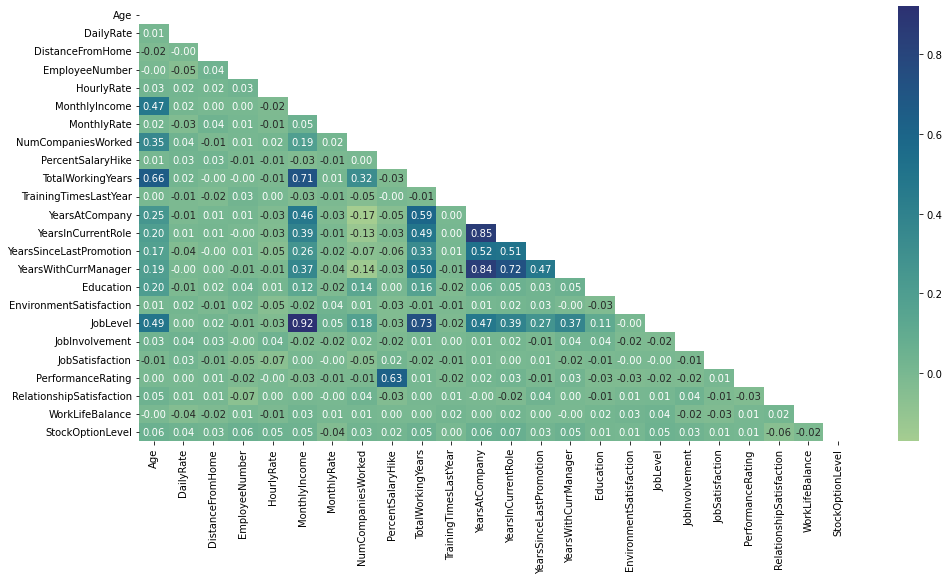

In [19]:
plt.figure(figsize = (16,8))

# check correlation of numerical variables using spearman
corr_mtrx= pd.concat([num_df, ordinal_df], axis =1).corr(method = 'spearman')
mask = np.triu(corr_mtrx)
sns.heatmap(corr_mtrx, annot=True, mask = mask, fmt = '.2f', cmap = 'crest')
plt.show()

# Correlation Summary
The following variables have a strong positive correlation<br>
 1. Monthly Income, Job Level and Total working years<br>
 2. Yearsatcompany, yearswithcurrmanager and yearsincurrentrole

# Data Splitting

In [21]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

#label encoding the target variable
le = LabelEncoder()
y = pd.Series(le.fit_transform(df.Attrition))

In [24]:
label_summary = pd.DataFrame(zip(y, df.Attrition), columns = ['label_encode', 'Attrition'])\
.groupby(['label_encode', 'Attrition']).size().to_frame('count').reset_index()
    
label_summary['%'] = round(label_summary['count']/label_summary['count'].sum()*100, 1)
label_summary

,label_encode,Attrition,count,%
0,0,No,1233,83.9
1,1,Yes,237,16.1


In [26]:
from sklearn.model_selection import train_test_split

#splitting into testing and training
X_train, X_test, y_train, y_test = train_test_split(df.drop('Attrition', axis = 1), y, test_size = 0.2,random_state = 778, shuffle = True, stratify = y)

# check distribution
pd.DataFrame({'Count - Train': y_train.value_counts(), '% - Train': round(y_train.value_counts(1)*100, 1),
              'Count - Test': y_test.value_counts(), '% - Test': round(y_test.value_counts(1)*100, 1)})

,Count - Train,% - Train,Count - Test,% - Test
0,986,83.8,247,84.0
1,190,16.2,47,16.0


In [28]:
#preprocessing
from sklearn.compose import ColumnTransformer

nominal = X_train.select_dtypes(include=['object']).columns
hot_enc = ColumnTransformer([('encoder', OneHotEncoder(), nominal)], remainder='passthrough')
hot_enc.fit(X_train)
X_train_new = hot_enc.transform(X_train)
X_test_new = hot_enc.transform(X_test)

# Model fitting

In [33]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier


models = [SVC(), DecisionTreeClassifier(), RandomForestClassifier(), XGBClassifier(), LGBMClassifier()]
models_name = ['SVM', 'Decision Tree', 'Random Forest', 'XGBoost', 'LGBM']

for i in range(0, len(models)):
    cv_results = cross_validate(models[i], X_train_new, y_train,
                            cv=StratifiedKFold(n_splits= 5, shuffle=True, random_state=3),
                            scoring = ['f1_macro', 'accuracy'])
    accuracy = round(cv_results['test_accuracy'].mean(), 2)
    f1_score = round(cv_results['test_f1_macro'].mean(), 2)
    print(f'Model: {models_name[i]} - Accuracy: {accuracy} - F1 Score: {f1_score}')

Model: SVM - Accuracy: 0.84 - F1 Score: 0.46
Model: Decision Tree - Accuracy: 0.78 - F1 Score: 0.62
Model: Random Forest - Accuracy: 0.86 - F1 Score: 0.61
Model: XGBoost - Accuracy: 0.86 - F1 Score: 0.68
Model: LGBM - Accuracy: 0.86 - F1 Score: 0.66


XGBoost and LGBm have the best performance (best perfrmance is closest to 1)

# Tuning Parameters

In [34]:
params = {'n_estimators': Integer(50, 150),
          'max_depth': Integer(3, 10),
          'learning_rate': Real(0.01, 1),
         'num_leaves': Integer(10, 20),
         'feature_fraction': Real(0.1, 0.9),
         'bagging_fraction': Real(0.8, 1),
         'min_data_in_leaf': Integer(20, 50)
         }

opt_cv = BayesSearchCV(LGBMClassifier(random_state = 2), params, n_iter = 5,
                      cv=StratifiedKFold(n_splits= 5, shuffle=True, random_state=3),
                      n_jobs = -1, scoring = 'f1_macro', refit = True,
                      random_state = 3, verbose = -1)

opt_cv.fit(X_train_new, y_train)

[LightGBM] [Warning] feature_fraction is set=0.23605943074829283, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.23605943074829283
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] bagging_fraction is set=0.9985476182348679, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9985476182348679


BayesSearchCV(cv=StratifiedKFold(n_splits=5, random_state=3, shuffle=True),
              estimator=LGBMClassifier(random_state=2), n_iter=5, n_jobs=-1,
              random_state=3, scoring='f1_macro',
              search_spaces={'bagging_fraction': Real(low=0.8, high=1, prior='uniform', transform='normalize'),
                             'feature_fraction': Real(low=0.1, high=0.9, prior='uniform', transform='normalize'),
                             'learning_...niform', transform='normalize'),
                             'max_depth': Integer(low=3, high=10, prior='uniform', transform='normalize'),
                             'min_data_in_leaf': Integer(low=20, high=50, prior='uniform', transform='normalize'),
                             'n_estimators': Integer(low=50, high=150, prior='uniform', transform='normalize'),
                             'num_leaves': Integer(low=10, high=20, prior='uniform', transform='normalize')},
              verbose=-1)

In [35]:
print(f' Best parameters: {opt_cv.best_params_}')
print(f' Best score: {round(opt_cv.best_score_, 2)}')

 Best parameters: OrderedDict([('bagging_fraction', 0.9985476182348679), ('feature_fraction', 0.23605943074829283), ('learning_rate', 0.2798988262556785), ('max_depth', 7), ('min_data_in_leaf', 23), ('n_estimators', 129), ('num_leaves', 20)])
 Best score: 0.7


# Model Evaluation

              precision    recall  f1-score   support

           0       0.88      0.98      0.93       247
           1       0.72      0.28      0.40        47

    accuracy                           0.87       294
   macro avg       0.80      0.63      0.66       294
weighted avg       0.85      0.87      0.84       294



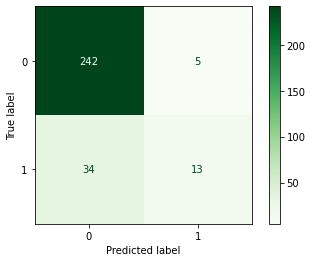

In [36]:
y_pred = opt_cv.predict(X_test_new)
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap = 'Greens')

The F1 score is 0.66 from 0.63 while accuracy is 0.87. However, the model is unable to properly classify employees that will attrite.